In [14]:
import os
import sys
import rdflib
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [143]:
get_mid = lambda uri: uri.replace("http://rdf.freebase.com/ns", "")


def get_sequences(filename, sep=" ", min_len=1):
    for line in open(filename, "r"):
        sequence = line.split(sep)
        # tofix -> removing the \n at the end of the line
        sequence[-1] = sequence[-1][:-1]
        if len(sequence) >= min_len:
            yield sequence
            
def scatter_plot(two_dim_vecs, word_labels=None, colors="#00897B", user="chrispolo", api_key="89nned6csl"):
    py.sign_in(user, api_key)

    x_coord = two_dim_vecs[:, 0]
    y_coord = two_dim_vecs[:, 1]

    trace = go.Scattergl(
        x = x_coord, #
        y = y_coord, #
        mode = 'markers',
        text = word_labels, #
        marker = dict(
            color = colors,
            line = dict(width = 1)
        )
    )

    data = [trace]
    return data

def get_types(resource, graph=dbpedia_type_graph):
    prep_query = sparql.prepareQuery("""
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        SELECT ?type
        WHERE { 
          ?resource rdf:type ?type .
        }
    """)
    resource = rdflib.URIRef(resource)
    return graph.query(prep_query, initBindings={'resource': resource})

In [4]:
%%time
dbpedia_type_graph = rdflib.Graph()
dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 17min 17s, sys: 1min 29s, total: 18min 47s
Wall time: 21min 6s


In [3]:
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

### Training the Model

In [18]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [82]:
%%time
mid2types = dict()
for uri in model.vocab:
    mid = uri.replace("http://rdf.freebase.com/ns", "")
    if mid in mid2dbpedia:
        dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
        mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri)}
        if len(mid_types) > 0:
            mid2types[mid] = mid_types

CPU times: user 15min 46s, sys: 1min, total: 16min 47s
Wall time: 17min 52s


### Dimensionality reduction of embeddings

In [19]:
%%time
mid_prefix = "http://rdf.freebase.com/ns/m/"

embeddings = [model[uri] for uri in model.vocab]
uris = [uri for uri in model.vocab]
# colors = [ "#00897B" if uri.startswith(mid_prefix) else "#FFEB3B" for uri in model.vocab]

tsne = TSNE(n_components=2)
twodim_embeddings = tsne.fit_transform(embeddings)

CPU times: user 6min 5s, sys: 1min 33s, total: 7min 38s
Wall time: 6min 40s


In [176]:
colors = ["#FFEB3B" if "<http://dbpedia.org/ontology/Work>" in mid2types.get(get_mid(uri), []) else "#00897B" for uri in model.vocab]

In [ ]:
mids   = []
labels = []
for mid in mid2types:
    if 

In [21]:
hand = "http://rdf.freebase.com/ns/m/01dyvs"
palm = "http://rdf.freebase.com/ns/m/0479b"
foot = "http://rdf.freebase.com/ns/m/0f4_l"

# model.most_similar(positive=[hand, palm], negative=[foot], topn=15)
model.most_similar("http://rdf.freebase.com/ns/m/01dyvs", topn=15)

[('http://rdf.freebase.com/ns/m/04ktcgn', 0.9826288223266602),
 ('http://rdf.freebase.com/ns/m/01gb54', 0.9790093898773193),
 ('http://rdf.freebase.com/ns/award/award_nominated_work/award_nominations./award/award_nomination/nominated_for',
  0.9780914187431335),
 ('http://rdf.freebase.com/ns/m/048rn', 0.9775631427764893),
 ('http://rdf.freebase.com/ns/m/06_wqk4', 0.9769832491874695),
 ('http://rdf.freebase.com/ns/tv/tv_network/programs./tv/tv_network_duration/program',
  0.9757041931152344),
 ('http://rdf.freebase.com/ns/m/04x4gw', 0.9755406379699707),
 ('http://rdf.freebase.com/ns/m/025twgf', 0.975533127784729),
 ('http://rdf.freebase.com/ns/m/02p86pb', 0.9748035073280334),
 ('http://rdf.freebase.com/ns/m/01kf3_9', 0.9747480154037476),
 ('http://rdf.freebase.com/ns/m/0ndwt2w', 0.9744546413421631),
 ('http://rdf.freebase.com/ns/film/film/prequel', 0.9742667078971863),
 ('http://rdf.freebase.com/ns/m/0cjdk', 0.974242627620697),
 ('http://rdf.freebase.com/ns/m/0jwvf', 0.9738646149635315)

### Plot

In [177]:
scatter_data = scatter_plot(twodim_embeddings, uris, colors=colors)
py.iplot(scatter_data, filename='Data')

Check it [here](https://plot.ly/create/?fid=chrispolo:1238)

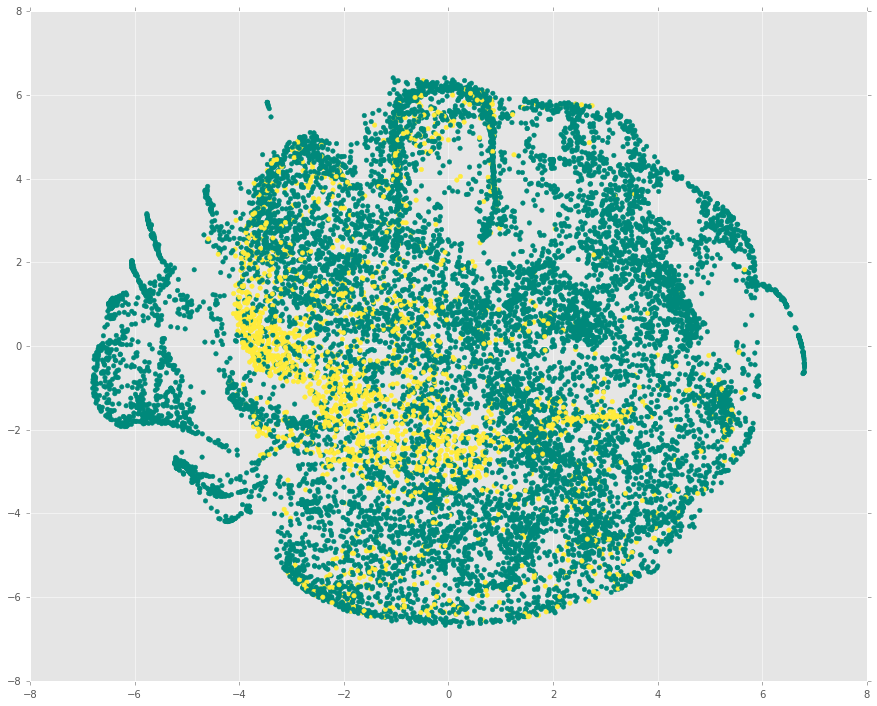

In [178]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodim_embeddings]
y = [point[1] for point in twodim_embeddings]
plt.scatter(x, y, color=colors)
plt.show()